In the dynamic landscape of air travel, understanding and predicting occupancy trends are vital. Harnessing machine learning, this study redefines occupancy analysis. By examining historical data, passenger behaviors, economic cues, and weather influences, we aim to optimize operations and elevate passenger satisfaction. This paper outlines our methods, data sources, and potential outcomes, ushering in data-driven aviation decision-making.
Check it out!

In [122]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [123]:
df = pd.read_csv('Airports2.csv')
df.head()

,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Occupancy,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population
0,MHK,AMW,"Manhattan, KS","Ames, IA",21,0.70,30,1,254,10/1/2008,122049,86219
1,EUG,RDM,"Eugene, OR","Bend, OR",41,0.10,396,22,103,11/1/1990,284093,76034
2,EUG,RDM,"Eugene, OR","Bend, OR",88,0.26,342,19,103,12/1/1990,284093,76034
3,EUG,RDM,"Eugene, OR","Bend, OR",11,0.15,72,4,103,10/1/1990,284093,76034
4,MFR,RDM,"Medford, OR","Bend, OR",0,0.00,18,1,156,2/1/1990,147300,76034


In [124]:
duplicate_counts = df.groupby(['Origin_city', 'Destination_city']).size().reset_index(name='Count')

# Find the top 10 duplicates
top_duplicates = duplicate_counts.nlargest(10, 'Count')

# Print the names of the top 10 duplicates
for index, row in top_duplicates.iterrows():
    origin_city = row['Origin_city']
    destination_city = row['Destination_city']
    count = row['Count']
    print(f"Origin City: {origin_city}, Destination City: {destination_city}, Count: {count}")

Origin City: Houston, TX, Destination City: Dallas, TX, Count: 7017
Origin City: Detroit, MI, Destination City: Chicago, IL, Count: 6320
Origin City: New York, NY, Destination City: Chicago, IL, Count: 6202
Origin City: Chicago, IL, Destination City: Detroit, MI, Count: 6009
Origin City: Minneapolis, MN, Destination City: Chicago, IL, Count: 5677
Origin City: New York, NY, Destination City: Miami, FL, Count: 5371
Origin City: Atlanta, GA, Destination City: Chicago, IL, Count: 4720
Origin City: Cleveland, OH, Destination City: Chicago, IL, Count: 4662
Origin City: Chicago, IL, Destination City: Atlanta, GA, Count: 4640
Origin City: Newark, NJ, Destination City: Chicago, IL, Count: 4559


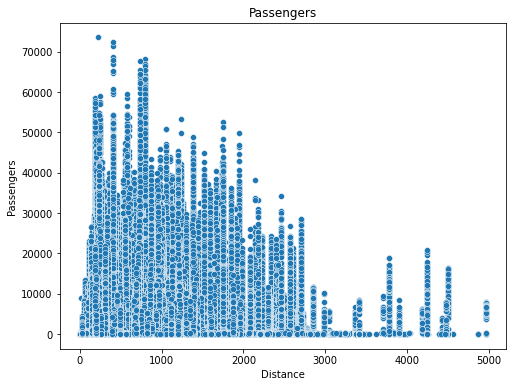

In [125]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Distance', y='Passengers')
plt.title('Passengers')
plt.xlabel('Distance')
plt.ylabel('Passengers')
plt.show()

In [126]:
df['Fly_date'] = pd.to_datetime(df['Fly_date'])

In [127]:
# Extract day of the week and month as features
df['DayOfWeek'] = df['Fly_date'].dt.dayofweek
df['Month'] = df['Fly_date'].dt.month

In [128]:
df = df.replace('#DIV/0!', pd.NA)  # Replace '#DIV/0!' with missing value representation


In [129]:
df = df.dropna(subset=['Seats', 'Passengers', 'Flights', 'DayOfWeek', 'Month',])


In [130]:
features = ['Seats', 'Flights', 'DayOfWeek', 'Month']


In [131]:
columns_of_interest = ['Passengers', 'Occupancy', 'Fly_date', 'Distance']


In [132]:
subset_df = df[columns_of_interest]

In [133]:
# Calculate the correlation matrix
correlation_matrix = subset_df.corr()


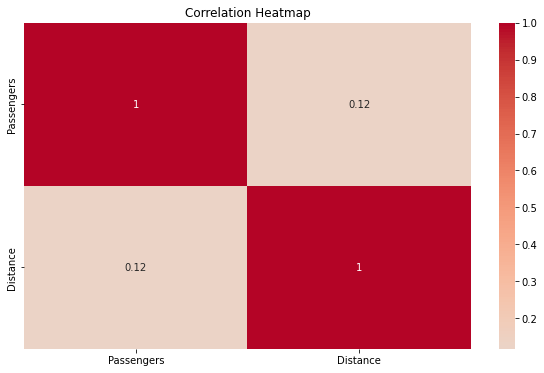

In [134]:
# Create a heatmap using seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()

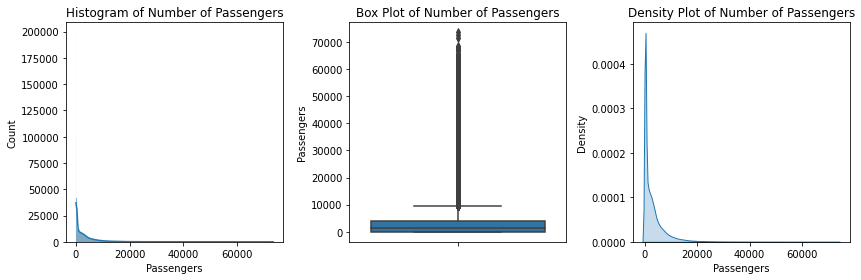

In [135]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
sns.histplot(data=df, x='Passengers', kde=True)
plt.title('Histogram of Number of Passengers')

plt.subplot(1, 3, 2)
sns.boxplot(data=df, y='Passengers')
plt.title('Box Plot of Number of Passengers')

plt.subplot(1, 3, 3)
sns.kdeplot(data=df, x='Passengers', fill=True)
plt.title('Density Plot of Number of Passengers')

plt.tight_layout()
plt.show()


In [136]:
X_train, X_valid, y_train, y_valid = train_test_split(df[features], df['Passengers'],
                                                      test_size=0.2, random_state=42)


In [137]:
# Reduce dataset size
sample_size = 10000  # Adjust the sample size as needed
X_train = X_train.sample(n=sample_size, random_state=42)
y_train = y_train.sample(n=sample_size, random_state=42)

In [138]:
# Initialize and train XGBoost model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [143]:
predictions = model.predict(X_valid)


In [144]:
# Evaluate the model
rmse = mean_squared_error(y_valid, predictions, squared=False)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 1124.3385247846572


In [148]:
# Prepare the features for the next year
next_year_start = df['Fly_date'].max() + pd.DateOffset(days=1)
next_year_end = next_year_start + pd.DateOffset(years=1)
date_range_year = pd.date_range(next_year_start, next_year_end, freq='D')

next_year_data = []
for date in date_range_year:
    next_year_data.append({
        'Seats': 150,
        'Flights': 1,
        'DayOfWeek': date.dayofweek,
        'Month': date.month,
        # Include other relevant columns based on your training data
    })

In [149]:
next_year_df = pd.DataFrame(next_year_data)

next_year_predictions = model.predict(next_year_df)

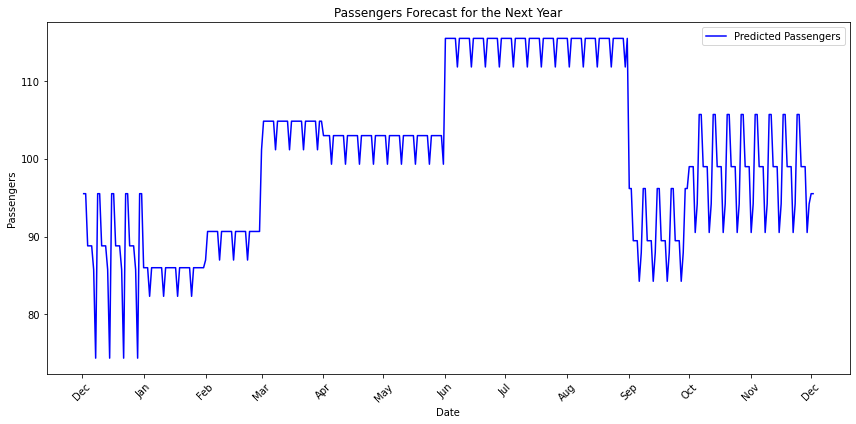

In [156]:
plt.figure(figsize=(12, 6))
plt.plot(date_range_year, next_year_predictions, label='Predicted Passengers', color='blue')
plt.title('Passengers Forecast for the Next Year')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()

# Format the x-axis ticks
months = mdates.MonthLocator()  # Choose the placement of the months
months_fmt = mdates.DateFormatter('%b')  # Use the abbreviated month names

plt.gca().xaxis.set_major_locator(months)
plt.gca().xaxis.set_major_formatter(months_fmt)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()





